In [1]:
import pandas as pd
import scipy.stats as sps
from fitter import Fitter, get_common_distributions, get_distributions
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score # for classification problem
from sklearn.metrics import mean_absolute_error # for regression problem
from sklearn.model_selection import cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import dataframe_image as dfi
import numpy as np
from numpy import mean, std, absolute

In [2]:
df = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI Launch/project2-MDdataCleaning/data-explore/combine.csv')

In [3]:
df

,Unnamed: 0,sr-only,location-info__office-loc 2,location-info__distance,review_number,provider_detail,feats,feats1,feats2
0,0,4-5,0,0-20,50-75,17,3,4,0
1,1,4-5,0,0-20,175-400,17,5,1,2
2,2,4-5,0,0-20,50-75,17,5,1,2
3,3,4-5,0,0-20,25-50,17,5,1,2
4,4,4-5,0,0-20,25-50,17,3,4,0
...,...,...,...,...,...,...,...,...,...
1384,1384,-1.0,5,0-20,>400,17,0,0,1
1385,1385,-1.0,5,0-20,>400,17,0,0,1
1386,1386,-1.0,5,0-20,>400,17,0,0,1
1387,1387,-1.0,5,0-20,>400,17,0,0,1


In [4]:
dataset = df.values
dataset

array([[0, '4-5', 0, ..., 3, 4, 0],
       [1, '4-5', 0, ..., 5, 1, 2],
       [2, '4-5', 0, ..., 5, 1, 2],
       ...,
       [1386, '-1.0', 5, ..., 0, 0, 1],
       [1387, '-1.0', 5, ..., 0, 0, 1],
       [1388, '-1.0', 5, ..., 0, 0, 1]], dtype=object)

In [5]:
X_reg = dataset[:, [2, 3, 5, 6, 7, 8]]
y_reg = dataset[:, [1, 4]]

In [6]:
X_class_1 = dataset[:, [1, 2, 3, 5, 6, 7, 8]]
y_class_1 = dataset[:, 4] # review number
X_class_2 = dataset[:, [2, 3, 4, 5, 6, 7, 8]]
y_class_2 = dataset[:, 1] # sr-only

In [7]:
# map the name of column for correlation use
mapping_x1 = []
for i in [1, 2, 3, 5, 6, 7, 8]:
    mapping_x1.append(df.columns[i])
mapping_x2 = []
for i in [2, 3, 4, 5, 6, 7, 8]:
    mapping_x2.append(df.columns[i])

In [8]:
X_reg = X_reg.astype(str)
X_class_1 = X_class_1.astype(str)
X_class_2 = X_class_2.astype(str)

# classification method

In [9]:
X_train_class1, X_test_class1, y_train_class1, y_test_class1 = train_test_split(X_class_1, y_class_1, test_size=0.3, random_state=1) # 0.3 testing 0.7 for training
X_train_class2, X_test_class2, y_train_class2, y_test_class2 = train_test_split(X_class_2, y_class_2, test_size=0.3, random_state=1)

In [10]:
# summarize
for i in range(2):
    print('Train', vars()['X_train_class'+str(i+1)].shape, vars()['y_train_class'+str(i+1)].shape)
    print('Test', vars()['X_test_class'+str(i+1)].shape, vars()['y_test_class'+str(i+1)].shape)

Train (972, 7) (972,)
Test (417, 7) (417,)
Train (972, 7) (972,)
Test (417, 7) (417,)


In [11]:
# prepare input data use OrdinalEncoder
# OrdinalEncoder() from scikit-learn to encode each variable to integers
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [12]:
for i in range(2):
    vars()['X_train_enc'+str(i + 1)], vars()['X_test_enc'+str(i + 1)] = prepare_inputs(vars()['X_train_class'+str(i + 1)], vars()['X_test_class' + str(i + 1)]) 
    vars()['y_train_enc'+str(i + 1)], vars()['y_test_enc'+str(i + 1)] = prepare_targets(vars()['y_train_class'+str(i + 1)], vars()['y_test_class' + str(i + 1)]) 

In [13]:
X_train_enc1.shape

(972, 7)

In [14]:
X_train_enc1[0]

array([3., 4., 4., 8., 0., 0., 1.])

In [15]:
# check the correlation
cor = {'review_number': y_train_enc1}
for i in range(1, 8):
    cor[mapping_x1[i - 1]] = X_train_enc1[:, i - 1]
cor = pd.DataFrame(cor)
cor

,review_number,sr-only,location-info__office-loc 2,location-info__distance,provider_detail,feats,feats1,feats2
0,0,3.0,4.0,4.0,8.0,0.0,0.0,1.0
1,8,0.0,4.0,0.0,1.0,0.0,0.0,1.0
2,0,4.0,4.0,4.0,8.0,5.0,1.0,2.0
3,0,3.0,6.0,0.0,8.0,5.0,1.0,1.0
4,5,3.0,6.0,0.0,22.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
967,8,0.0,4.0,4.0,8.0,0.0,0.0,1.0
968,8,0.0,8.0,3.0,8.0,0.0,0.0,1.0
969,0,4.0,4.0,0.0,8.0,5.0,1.0,2.0
970,0,2.0,5.0,0.0,8.0,1.0,0.0,1.0


In [16]:
cormat = cor.corr(method='pearson')
cormat1 = cormat.style.background_gradient(cmap='coolwarm').format(precision=2)
# print(cormat1.to_latex())
cormat1

,review_number,sr-only,location-info__office-loc 2,location-info__distance,provider_detail,feats,feats1,feats2
review_number,1.00,-0.79,0.02,-0.03,-0.02,-0.60,-0.38,-0.34
sr-only,-0.79,1.00,-0.11,0.04,0.05,0.83,0.57,0.41
location-info__office-loc 2,0.02,-0.11,1.00,-0.08,-0.05,-0.07,-0.09,-0.02
location-info__distance,-0.03,0.04,-0.08,1.00,0.04,0.02,0.05,-0.01
provider_detail,-0.02,0.05,-0.05,0.04,1.00,-0.01,0.06,-0.05
feats,-0.60,0.83,-0.07,0.02,-0.01,1.00,0.41,0.55
feats1,-0.38,0.57,-0.09,0.05,0.06,0.41,1.00,-0.15
feats2,-0.34,0.41,-0.02,-0.01,-0.05,0.55,-0.15,1.00


In [17]:
# dfi.export(cormat1, '/Users/jennyhuang/Documents/jobs/DBC-AI Launch/project2-MDdataCleaning/model/correlation.png')

In [18]:
y_train_enc1.shape

(972,)

In [19]:
y_train_enc2.shape

(972,)

In [20]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train) # Reduce X to the selected features.
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [21]:
feature_name = {}
names = df.columns
for i in range(1, len(names)):
    feature_name[i - 1] = names[i]
feature_name

{0: 'sr-only',
 1: 'location-info__office-loc 2',
 2: 'location-info__distance',
 3: 'review_number',
 4: 'provider_detail',
 5: 'feats',
 6: 'feats1',
 7: 'feats2'}

Feature 0: 1032.803508
Feature 1: 33.323659
Feature 2: 7.047352
Feature 3: 39.189656
Feature 4: 1002.285728
Feature 5: 371.851265
Feature 6: 61.007442


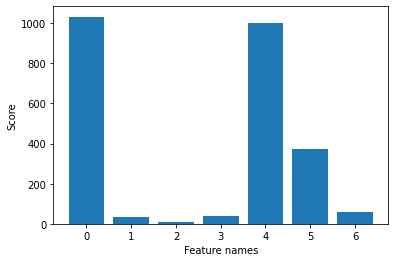

In [22]:
# feature selection for y_train_enc1 (review_number)
X_train_fs1, X_test_fs1, fs1 = select_features(X_train_enc1, y_train_enc1, X_test_enc1)
# what are scores for the features
for i in range(len(fs1.scores_)):
    print('Feature %d: %f' % (i, fs1.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs1.scores_))], fs1.scores_)
plt.xlabel('Feature names')
plt.ylabel('Score')
plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI Launch/project2-MDdataCleaning/model/feature1.png', bbox_inches='tight')
# result shows that the sr-only effects review_number mostly, then feats 2 then location info2

Feature 0: 18.927337
Feature 1: 3.200193
Feature 2: 2779.373843
Feature 3: 17.756385
Feature 4: 1330.800413
Feature 5: 534.199561
Feature 6: 93.874274


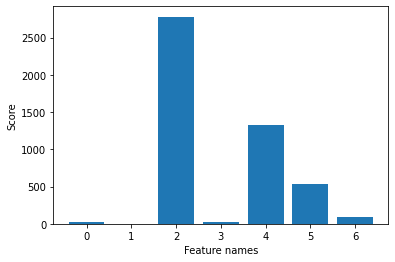

In [23]:
# feature selection for y_train_enc2 (sr-only)
X_train_fs2, X_test_fs2, fs2 = select_features(X_train_enc2, y_train_enc2, X_test_enc2)
# what are scores for the features
for i in range(len(fs2.scores_)):
    print('Feature %d: %f' % (i, fs2.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
plt.xlabel('Feature names')
plt.ylabel('Score')
plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI Launch/project2-MDdataCleaning/model/feature2.png', bbox_inches='tight')
# plt.show()
# the result shows the review_number effects sr-only the most, then location info 2 then feats 2

## decision tree classification model

In [24]:
# fit the model for review_number
model = DecisionTreeClassifier()
model.fit(X_train_fs1, y_train_enc1)
# evaluate the model
yhat = model.predict(X_test_fs1)
# evaluate predictions
accuracy = accuracy_score(y_test_enc1, yhat)
print('Accuracy: %.2f' % (accuracy*100) + '%') # 79.38%
# error = mean_absolute_error(y_test_enc1, yhat)
# print('MAE: %.3f' % (error))

Accuracy: 77.94%


In [25]:
# fit the model for sr-only
model = DecisionTreeClassifier()
model.fit(X_train_fs2, y_train_enc2)
# evaluate the model
yhat = model.predict(X_test_fs2)
# evaluate predictions
accuracy = accuracy_score(y_test_enc2, yhat)
print('Accuracy: %.2f' % (accuracy*100) + '%') # 83.21%
# error = mean_absolute_error(y_test_enc1, yhat)
# print('MAE: %.3f' % (error))

Accuracy: 90.65%


## try rfe with DecisionTreeClassifier

In [26]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1) # If your target variable is continuous then use simple KFold cross validation instead of StratifiedKFold.
n_scores = cross_val_score(pipeline, X_train_enc1, y_train_enc1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
n_scores1 = cross_val_score(pipeline, X_train_enc2, y_train_enc2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %.3f (%.3f)" % (mean(n_scores), std(n_scores)))
n_scores1 = absolute(n_scores1)
print("MAE: %.3f (%.3f)" % (mean(n_scores1), std(n_scores1)))

/Users/jennyhuang/yes/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/jennyhuang/yes/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/jennyhuang/yes/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Accuracy: 0.801 (0.012)
MAE: 0.100 (0.016)


In [27]:
rfe.fit(X_train_enc1, y_train_enc1)
# summarize all features
for i in range(X_train_enc1.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 3.000
Column: 4, Selected False, Rank: 4.000
Column: 5, Selected False, Rank: 5.000
Column: 6, Selected False, Rank: 2.000


In [28]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1) # If your target variable is continuous then use simple KFold cross validation instead of StratifiedKFold.
n_scores = cross_val_score(pipeline, X_train_enc2, y_train_enc2, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
n_scores1 = cross_val_score(pipeline, X_train_enc2, y_train_enc2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %.3f (%.3f)" % (mean(n_scores), std(n_scores)))
n_scores1 = absolute(n_scores1)
print("MAE: %.3f (%.3f)" % (mean(n_scores1), std(n_scores1)))

Accuracy: 0.912 (0.018)
MAE: 0.102 (0.017)


In [29]:
rfe.fit(X_train_enc2, y_train_enc2)
# summarize all features
for i in range(X_train_enc1.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 2.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 5.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000


In [30]:
feature_name

{0: 'sr-only',
 1: 'location-info__office-loc 2',
 2: 'location-info__distance',
 3: 'review_number',
 4: 'provider_detail',
 5: 'feats',
 6: 'feats1',
 7: 'feats2'}

In [31]:
X_train_enc1.shape

(972, 7)

# regression method

In [32]:
names

Index(['Unnamed: 0', 'sr-only', 'location-info__office-loc 2',
       'location-info__distance', 'review_number', 'provider_detail', 'feats',
       'feats1', 'feats2'],
      dtype='object')

In [33]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=1) # 0.3 testing 0.7 for training

In [34]:
X_train_enc, X_test_enc = prepare_inputs(X_train_reg, X_test_reg)
y_train_enc = np.append([y_train_enc1], [y_train_enc2], axis=0)

In [35]:
y_train_enc = y_train_enc.transpose()

## without feature selection(RFE)

In [36]:
model = DecisionTreeRegressor()
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # If your target variable is continuous then use simple KFold cross validation instead of StratifiedKFold.
n_scores = cross_val_score(model, X_train_enc, y_train_enc, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = absolute(n_scores)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 1.212 (0.124)


## with feature selection(RFE)

In [37]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=3)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_enc, y_train_enc, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 1.306 (0.129)


In [38]:
# see the feature selection result
rfe.fit(X_train_enc, y_train_enc)
for i in range(X_train_enc.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 2.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected False, Rank: 4.000


In [39]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=1)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_enc, y_train_enc, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 1.384 (0.105)


In [40]:
# see the feature selection result
rfe.fit(X_train_enc, y_train_enc)
for i in range(X_train_enc.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 2.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected False, Rank: 4.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 5.000
Column: 5, Selected False, Rank: 6.000


In [41]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=2)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_enc, y_train_enc, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
n_scores = absolute(n_scores)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: 1.336 (0.102)


In [42]:
# see the feature selection result
rfe.fit(X_train_enc, y_train_enc)
for i in range(X_train_enc.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 2.000
Column: 2, Selected False, Rank: 3.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 4.000
Column: 5, Selected False, Rank: 5.000
